In [45]:
!pip install ortools

# Worksheet 5: Using CSP in practice

As you may remember from the lectures, CSP is very flexible in terms of defining constraints; any relation between the scope variables can be used as a constraint.  We do not have to use any restricted language, such as propositional logic or FOL, to describe a constraint; any constraint is a CSP constraint as long as its logic depends only on the scope variables and it can be described formally and deterministically.

However, how do you describe a constraint using OR-Tools?
OR-Tools has functions to describe the most typical constraints:
* You can use the [`Add`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#add) function passing some equality or inequality into it; e.g., `model.Add(x + 2 * y > 5)`.

* You can use the [`AddAllDifferent`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addalldifferent) function to request that all the scope variables have different values; e.g. `model.AddAllDifferent([x, y])`.

* Functions [`AddImplication`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addimplication), [`AddBoolOr`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addboolor), [`AddBoolAnd`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addbooland) and [`AddBoolXOr`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addboolxor) create constraints connecting several Boolean variables.

* Functions such as [`AddDivisionEquality`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#adddivisionequality), [`AddMaxEquality`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addmaxequality) and [`AddModuloEquality`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addmoduloequality) provide access to certain arithmetic operations; you have seen an example of using `AddMaxEquality` in the previous worksheet.

* There are several other functions designed to create specialised constraints, e.g. [`AddCircuit`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addcircuit) and [`AddReservoirConstraintWithActive`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addreservoirconstraint) which are not used that commonly.

* You can use the [`AddAllowedAssignments`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addallowedassignments) and [`AddForbiddenAssignments`](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addforbiddenassignments) functions to explicitly list all the allowed/forbidden assignments&nbsp;&ndash; effectively using the truth table approach to defining a constraint.  While you can use this method to define any CSP constraint as long as your variable domains are finite, this is usually a _very_ inefficient approach.


All of these approaches (except for the last one, which should not normally be used) are restricted to common but very specific types of constraints.
This week, you will learn how to encode constraints that cannot be created directly using the above functions.

**Note** that the exercises below give mathematically precise CSP formulations, however such formulations would not be sufficient in the Coursework Project report because they cannot be directly used in software such as OR-Tools.  For the Coursework Project report, you would need to use the mathematical notations that can trivially be encoded in OR-Tools.  For example, OR-Tools does not support a constraint testing if one set is a subset of another set; you will probably need auxiliary variables to implement it, and your report must show those auxiliary constraints.

**Exercise 1.**  Encode in Python/OR-Tools the following CSP:
$$
\begin{align}
& x + y < 5 \quad \text{or} \quad z - x > 3, \\
& 0 \le x, y, z \le 10.
\end{align}
$$

**Hint:** introduce an auxiliary Boolean variable.  Depending on the value of that new variable, either the first or the second part of the constraint will be enforced.  Use `OnlyEnforceIf` to conditionally enforce a constraint.

In [ ]:
# Your solution to Exercise 1
from ortools.sat.python import cp_model
model = cp_model.CpModel()
x = model.NewIntVar(0, 10, 'x')
y = model.NewIntVar(0, 10, 'y')
z = model.NewIntVar(0, 10, 'z')

a = model.NewBoolVar('a')
b = model.NewBoolVar('b')

model.Add(x + y < 5).OnlyEnforceIf(a)

model.Add(z - x > 3).OnlyEnforceIf(b)


model.AddBoolOr([a,b])
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    # Print the solution
    print(f'x = {solver.Value(x)}')
    print(f'y = {solver.Value(y)}')
    print(f'z = {solver.Value(z)}')
    # print(f'a = {bool(solver.Value(a))}')
    # print(f'b = {bool(solver.Value(b))}')
else:
    print('unsat')


x = 0
y = 0
z = 4


**Exercise 2.**  Generalise the above approach to encode the following CSP:
$$
\begin{align}
& \exists i \in N \text{ such that } x_i = 3, \\
& x_i \in N \qquad \forall i \in  N,
\end{align}
$$
where $N = \{ 1, 2, \ldots, 10 \}$.

**Hint:** think of the way to expand the existential quantifier; what does the first constraint really mean?


In [ ]:
# Your solution to Exercise 2
from ortools.sat.python import cp_model
model = cp_model.CpModel()


solver = cp_model.CpSolver()
status = solver.Solve(model)

n = 10
x = [model.NewIntVar(1, n, f'x_{i}') for i in range (1,n+1)]
a = [model.NewBoolVar(f'a_{i}') for i in range (1,n+1)]

for i in range (1,n+1):
  # print(i)
  model.Add(x[i-1] == 3).OnlyEnforceIf(a[i-1])
  # model.Add(x[i-1] != 3).OnlyEnforceIf(a[i-1].Not())


model.AddBoolOr(a)

# model.AddAllDifferent(x)
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    # Print the solution
    for i in range (1,n+1):
      print(f'x[{i}] = {solver.Value(x[i-1])}')
else:
    print('unsat')


x[1] = 3
x[2] = 1
x[3] = 1
x[4] = 1
x[5] = 1
x[6] = 1
x[7] = 1
x[8] = 1
x[9] = 1
x[10] = 1


**Exercise 3.**  Further generalise the above approach to encode the following CSP:
$$
\begin{align}
& \exists M \subset N \text{ such that } |M| = 5 \land \big(\forall i \in M \, . \, (x_i = 3) \big), \\
& x_i \in N \qquad \forall i \in  N,
\end{align}
$$
where $N = \{ 1, 2, \ldots, 10 \}$.

**Hint:** similarly to the previous question, try interpreting the meaning of the constraint; how can you express it in English?
It can actually be explained in a short English sentence.

**Hint:** note that you can count the number of Boolean CSP variables set to True by using the Python `sum` function.


In [52]:
# Your solution to Exercise 3
from ortools.sat.python import cp_model
model = cp_model.CpModel()
#five elements == 3


n = 10
x = [model.NewIntVar(1, n, f'x_{i}') for i in range (1,n+1)]
a = [model.NewBoolVar(f'a_{i}') for i in range (1,n+1)]
m = 5

for i in range (1,n+1):
  # print(i)
  model.Add(x[i-1] == 3).OnlyEnforceIf(a[i-1])
  # model.Add(x[i-1] != 3).OnlyEnforceIf(a[i-1].Not())


model.AddBoolOr(a)

model.Add(sum(a) == m)
# model.Add(x[1] == 3)

# model.AddAllDifferent(x)
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    # Print the solution
    for i in range (1,n+1):
      print(f'x[{i}] = {solver.Value(x[i-1])}')
else:
    print('unsat')


x[1] = 1
x[2] = 1
x[3] = 1
x[4] = 1
x[5] = 1
x[6] = 3
x[7] = 3
x[8] = 3
x[9] = 3
x[10] = 3


**Exercise 4.**  Encode a slight modification of the above problem:
$$
\begin{align}
& |\{ i : x_i = 3 \}| = 5, \\
& x_i \in N \qquad \forall i \in N,
\end{align}
$$
where $N = \{ 1, 2, \ldots, 10 \}$.

Observe that we want _exactly_ five of the constraints $x_i = 3$ to be satisfied.

Test your encoding by replacing the second line with
$$
x_i \in \{ 3 \} \qquad \forall i \in N.
$$
If your encoding is correct, the problem should become unsatisfiable.

In [50]:
# Your solution to Exercise 4
from ortools.sat.python import cp_model
model = cp_model.CpModel()



n = 10
x = [model.NewIntVar(3, 3, f'x_{i}') for i in range (1,n+1)]
a = [model.NewBoolVar(f'a_{i}') for i in range (1,n+1)]
m = 5

for i in range (1,n+1):
  # print(i)
  model.Add(x[i-1] == 3).OnlyEnforceIf(a[i-1])
  model.Add(x[i-1] != 3).OnlyEnforceIf(a[i-1].Not())


model.AddBoolOr(a)

model.Add(sum(a) == m)
# model.Add(x[1] == 3)

# model.AddAllDifferent(x)
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    # Print the solution
    for i in range (1,n+1):
      print(f'x[{i}] = {solver.Value(x[i-1])}')
else:
    print('unsat')


unsat


**Exercise 5.**  This is the last computing exercise in this module, and it is advanced.  It is likely to take you some time to do but it will help you better understand the performance of solvers.

----

Recall the graph colouring problem from the lecture:

> Given an undirected graph $G = (V, E)$ and an integer $k$, find a proper vertex $k$-colouring of $G$, i.e. an assignment of $k$ colours to vertices $V$ such that no two adjacent nodes have the same colour.

You can find a few examples of graph colouring in [this Wikipedia article](https://en.wikipedia.org/wiki/Graph_coloring).

We produced the following formulation in the lecture:
$$
\begin{split}
& c_v \neq c_u & \qquad \forall (v, u) \in E, & \qquad (1)\\
& c_v \in \{ 1, 2, \ldots, k \} & \qquad \forall v \in V. & \qquad (2)
\end{split}
$$
Here $n$ is the number of nodes, $V = \{ 1, 2, \ldots, n \}$ is the set of nodes, $E$ is the set of graph edges, and each edge is a pair of nodes.

Our solution representation is the set of variables $c_v$, $v \in V$.  Specifically, the value of variable $c_v$ is the colour assigned to node $v$.

In this exercise, you will:
1. Build a solver (based on OR-Tools) for graph colouring.
2. Build a generator of random graphs.
3. Measure the performance of your solver on a range of graphs.
4. Measure the probability of a random graph with a certain number of nodes and edges being satisfiable.
5. Link the above probability to the running time of the solver.

<ins>Building a solver</ins>

Implement formulation (1)&ndash;(2) in OR-Tools.  Place it in a function that takes the graph and the value of $k$ as parameters, and returns a Boolean: `True` if the graph colouring problem is satisfiable and `False` otherwise.

**Hint:**  to represent a graph, all you need is the number of nodes $n$ and the list of edges.  For an edge, you can use Python tuple, e.g. `(4, 8)` would represent an edge between nodes 4 and 8.

<ins>Building a random graph generator</ins>

Implement a Python function that takes two parameters: the number of nodes $n$ and the number of edges $m$.  The function should produce a random graph with the given number of nodes and the given number of _distinct_ edges.

<ins>Measuring performance and satisfiability probability</ins>

The performance of a solver greatly depends on the specific graph (and the value of $k$); some instances happen to be easy while others happen to be hard.  To understand how the solver behaves on graphs of a certain size and certain values of $k$, we need to run multiple experiments and measure the average running time.  Implement a function that takes $n$, $m$ and $k$ as parameters and then runs the following loop (a reasonable number of iterations is somewhere between 10 and 100):
* Produce a random graph with $n$ nodes and $m$ edges;
* Solve the problem for $k$ colours;
* Note the time it took to solve the problem; and
* Note whether the instance was satisfiable.

In the end, return the average running time of the solver and the percentage of instances that were satisfiable.

**Note.**  Measuring performance of a solver takes considerable computational time.  For example, my model answer to this exercise takes a few minutes.  This is inevitable; indeed, if the instances are too easy, the running time is dominated by model creation and other overheads; then you cannot analyse the reasoning time.  However, building a software that runs multiple experiments, performs the measurements and visuases the results usually takes multiple iterations.  To save time, use small instances and few iterations while developing your answer, and once you are happy with your implementation, change the parameter values to run the final experiment.

<ins>Visualisation</ins>

Fix $n = 20$ and $m = 140$.  Run the above function for a range of values of $k$ (what is the range of meaningful values of $k$?).  Plot the average running time against $k$.  Plot the satisfiability probability against $k$.  Can you explain the results?

To plot a simple curve, you can use the following code:
```
import matplotlib.pyplot as plt
plt.plot(x, y)
```
Here $x$ and $y$ are lists of $x$-values and $y$-values, respectively.

**Note.**  You can try different values of $n$ and $m$.  Smaller $n$ will probably give very simple instances where the solution time is dominated by building the model and other overheads.  Significantly smaller or larger values of $m$ will also lead to simple instances.  

<ins>Variation of $m$</ins>

Follow the above steps to plot the average running time/satisfiability probability against $m$, i.e. against the number of edges in the graph.  Fix $k$ at some reasonable value, e.g., $k = 5$.

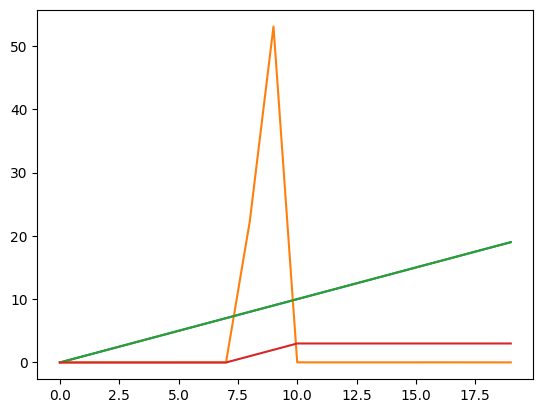

In [3]:
# Your solution to Exercise 5
import matplotlib.pyplot as plt
import random
from ortools.sat.python import cp_model
import time

# plt.plot(x, y)

n = 20
m = 140
k = 8
edge = [[False for _ in range(n)] for _ in range(n)]
def create_random_graph(n,m,edge):

  for i in range (n):
    for j in range (n):
      edge[i][j] = False

  while (m != 0):
    rand_node_1 = round(random.randrange(0,n-1))

    rand_node_2 = round(random.randrange(rand_node_1 +1,n))


    if(edge[rand_node_1][rand_node_2] == False):
      edge[rand_node_1][rand_node_2] = True
    else:
      m = m+1

    m = m-1
  return edge
def create_coord(n,edge):
  coord = []

  for i in range (n):
    for j in range (i,n):
      if (edge[i][j]):
        coord.append((i,j))
  return coord

def solve_problem(n,m,k,coord):
  model = cp_model.CpModel()


  num_edge = len (coord)
  c = [model.NewIntVar(1, k, f'c_{i}') for i in range (n)]
  for (v,u) in coord:
    model.Add(c[v] != c[u])


  solver = cp_model.CpSolver()
  status = solver.Solve(model)

  if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
    # Print the solution

    return(1)#sat
  else:
    return(0)#unsat

time_used = []
sat_num = []
for k in range (n):
  num_sat = 0
  time_total = 0
  for i in range (3):
    create_random_graph(n,m,edge)
    coord = create_coord(n,edge)
    start_time = time.time()
    temp = solve_problem(n,m,k,coord)
    end_time = time.time()

    time_total = time_total + (end_time - start_time)
    # time_used.append((k,(end_time - start_time)))

    num_sat = num_sat + temp

  sat_num.append((k, num_sat))
  aver_time = time_total / 3
  time_used.append((k,aver_time))

plt.plot(time_used)
plt.plot(sat_num)
# print(time_used)
# print(sat_num)
# print (edge)
# print(coord)
# print(len(coord))



